# Importing Libraries


In [40]:
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from scipy.spatial.distance import cdist
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression,OrthogonalMatchingPursuit, OrthogonalMatchingPursuit,  Lasso, Ridge
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from tensorflow.keras import layers
from tensorflow import keras
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor


import warnings
warnings.filterwarnings('ignore')

In [41]:
%matplotlib inline

# Loading the data

In [42]:
file_path = "data/Sensor_Data.xlsx"

dfs = []

with pd.ExcelFile(file_path) as xlsx:
    for sheet_name in xlsx.sheet_names:
        df = pd.read_excel(xlsx, sheet_name)
        dfs.append(df)

combined_df = df = pd.concat(dfs, ignore_index=True)
df = combined_df.copy()
df["Irradiance(W/m2)"] = df["Light Intensity(lumens)"]*0.079

mod_df = pd.DataFrame(columns= ["Timestamp", "Temperature(Â°C)", "Irradiance(W/m2)", "Power(Watts)"])
count = 0
while count <= 34433:
    temp = sum(df.iloc[count:count + 6]["Temperature(Â°C)"]) / len(df.iloc[0:6]["Temperature(Â°C)"])
    irr = sum(df.iloc[count:count + 6]["Irradiance(W/m2)"]) / len(df.iloc[0:6]["Irradiance(W/m2)"])
    power = sum(df.iloc[count:count + 6]["Power(Watts)"]) / len(df.iloc[0:6]["Power(Watts)"])
    time = df.iloc[count]["Timestamp"]

    count = count + 6

    mod_df = mod_df.append({"Timestamp": time, "Temperature(Â°C)":temp, "Irradiance(W/m2)":irr, "Power(Watts)": power }, ignore_index = True)

        
df  = mod_df.copy()

In [43]:
df

,Timestamp,Temperature(Â°C),Irradiance(W/m2),Power(Watts)
0,23 Feb 2023 10:07:38 Thu,23.250000,231.614833,170.959644
1,23 Feb 2023 10:08:41 Thu,24.100000,231.838667,171.577256
2,23 Feb 2023 10:09:44 Thu,23.833333,231.601667,171.367693
3,23 Feb 2023 10:10:48 Thu,23.600000,232.233667,172.439381
4,23 Feb 2023 10:11:51 Thu,23.133334,231.878167,172.854975
...,...,...,...,...
5734,28 Mar 2023 16:54:54 Tue,11.850000,119.566500,0.000000
5735,28 Mar 2023 16:55:57 Tue,11.850000,114.102333,0.000000
5736,28 Mar 2023 16:57:00 Tue,11.600000,107.097667,0.000000
5737,28 Mar 2023 16:58:04 Tue,11.483333,96.511667,0.000000


In [44]:
results = pd.DataFrame(columns=["Model_name", "RMSE"])

# Radial basis Neural Network

In [64]:


X = df[['Temperature(Â°C)', "Irradiance(W/m2)"]].values
y = df["Power(Watts)"].values

scaler_X =  MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

train_size = int(len(df) * 0.8)
X_train, X_test = X_scaled[:train_size], X_scaled[train_size:]
y_train, y_test = y_scaled[:train_size], y_scaled[train_size:]

class RBFNet(object):
    def __init__(self, input_dim, hidden_dim, output_dim, sigma=1.0):
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.sigma = sigma
        self.centers = None
        self.weights = None
        
    def _gaussian(self, x, center):
        return np.exp(-self.sigma*np.linalg.norm(x-center)**2)
    
    def _design_matrix(self, X):
        dist = cdist(X, self.centers)
        return np.array([self._gaussian(X[i], self.centers[j]) for i in range(len(X)) for j in range(len(self.centers))]).reshape((len(X), len(self.centers)))
    
    def fit(self, X, y):
        from sklearn.cluster import KMeans
        kmeans = KMeans(n_clusters=self.hidden_dim, random_state=0).fit(X)
        self.centers = kmeans.cluster_centers_
        phi = self._design_matrix(X)
        self.weights = np.linalg.lstsq(phi, y, rcond=None)[0]
        
    def predict(self, X):
        phi = self._design_matrix(X)
        y_pred = np.dot(phi, self.weights)
        return y_pred
    
    def summary(self):
        print("RBFNet Model Summary")
        print("--------------------")
        print(f"Input Dimension: {self.input_dim}")
        print(f"Hidden Dimension: {self.hidden_dim}")
        print(f"Output Dimension: {self.output_dim}")
        print(f"Sigma: {self.sigma}")

input_dim = 2
hidden_dim = 50
output_dim = 1
sigma = 1

rbfnet = RBFNet(input_dim, hidden_dim, output_dim, sigma)


rbfnet.fit(X_train, y_train)


y_pred = rbfnet.predict(X_test)

mse_1 = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse_1:.10f}')
print(f'\n')
rbfnet.summary()


Mean Squared Error: 0.0100455308


RBFNet Model Summary
--------------------
Input Dimension: 2
Hidden Dimension: 50
Output Dimension: 1
Sigma: 1


In [65]:
y_pred = rbfnet.predict(X_test)
y_pred_orig = scaler_y.inverse_transform(y_pred)

y_train_pred = rbfnet.predict(X_train)
y_train_pred_orig = scaler_y.inverse_transform(y_train_pred)

rmse_1 = np.sqrt(mean_squared_error(y[train_size:], y_pred_orig))

rmse_train = np.sqrt(mean_squared_error(y[:train_size], y_train_pred_orig))

print(f'Test Root Mean Squared Error: {rmse_1:.10f}')
print(f'Train Root Mean Squared Error: {rmse_train:.10f}')
print(f'\n')
rbfnet.summary()

Test Root Mean Squared Error: 22.8300962208
Train Root Mean Squared Error: 20.4267419840


RBFNet Model Summary
--------------------
Input Dimension: 2
Hidden Dimension: 50
Output Dimension: 1
Sigma: 1


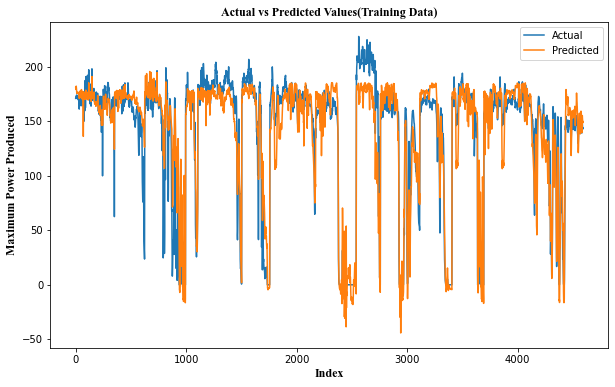

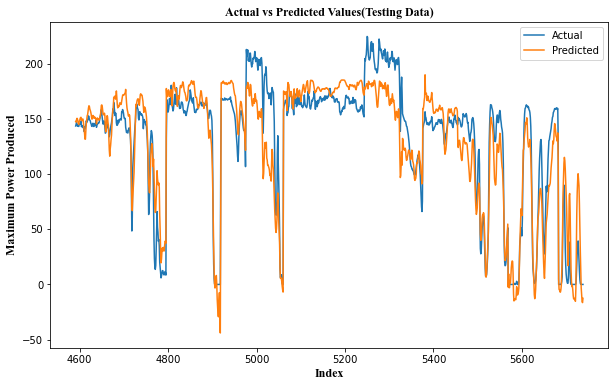

In [56]:
plt.figure(figsize=(10, 6))
plt.plot(df.index[:train_size], y[:train_size], label='Actual')
plt.plot(df.index[:train_size], y_train_pred_orig, label='Predicted')
plt.title("Actual vs Predicted Values(Training Data)", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xlabel("Index", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.ylabel("Maximum Power Produced", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xticks()
plt.yticks()
plt.legend()

plt.show()


plt.figure(figsize=(10, 6))
plt.plot(df.index[train_size:], y[train_size:], label='Actual')
plt.plot(df.index[train_size:], y_pred_orig, label='Predicted')
plt.title("Actual vs Predicted Values(Testing Data)" , fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xlabel("Index", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.ylabel("Maximum Power Produced", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xticks()
plt.yticks()
plt.legend(loc = 'upper right')

plt.show()


In [18]:
results = results.append({"Model_name":"Radial Basis Function Neural Network","RMSE": rmse_1}, ignore_index = True)
results

,Model_name,RMSE
0,Radial Basis Function Neural Network,29.71128


# LSTM

In [19]:
train_size = int(len(df) * 0.8)
train_data = df[:int(0.8 * len(df))].copy()
test_data = df[int(0.8 * len(df)):].copy()

scaler = MinMaxScaler()
train_data[['Temperature(Â°C)', "Irradiance(W/m2)", 'Power(Watts)']] = scaler.fit_transform(train_data[['Temperature(Â°C)', "Irradiance(W/m2)", 'Power(Watts)']])
train_data = train_data[['Temperature(Â°C)', "Irradiance(W/m2)", 'Power(Watts)']].copy()
test_data[['Temperature(Â°C)', "Irradiance(W/m2)", 'Power(Watts)']] = scaler.transform(test_data[['Temperature(Â°C)', "Irradiance(W/m2)", 'Power(Watts)']])
test_data = test_data[['Temperature(Â°C)', "Irradiance(W/m2)", 'Power(Watts)']].copy()

time_steps = 2

def create_sequences(dated_data, time_steps):
    X = []
    y = []
    for i in range(len(dated_data) - time_steps):        
        X.append(dated_data.iloc[i:i + time_steps, :2].values)
        y.append(dated_data.iloc[i + time_steps, 2])
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(train_data, time_steps)
X_test, y_test = create_sequences(test_data, time_steps)

X_train = X_train.reshape(-1, time_steps, 2)
X_test = X_test.reshape(-1, time_steps, 2)



model = Sequential()
model.add(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(loss='mse', optimizer=Adam(lr=0.001))
history = model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1, validation_data=(X_test, y_test))

Epoch 1/50
144/144 [==============================] - 9s 17ms/step - loss: 0.0831 - val_loss: 0.0381
Epoch 2/50
144/144 [==============================] - 1s 10ms/step - loss: 0.0334 - val_loss: 0.0316
Epoch 3/50
144/144 [==============================] - 2s 12ms/step - loss: 0.0286 - val_loss: 0.0308
Epoch 4/50
144/144 [==============================] - 2s 11ms/step - loss: 0.0271 - val_loss: 0.0317
Epoch 5/50
144/144 [==============================] - 2s 12ms/step - loss: 0.0262 - val_loss: 0.0330
Epoch 6/50
144/144 [==============================] - 2s 11ms/step - loss: 0.0254 - val_loss: 0.0292
Epoch 7/50
144/144 [==============================] - 1s 10ms/step - loss: 0.0247 - val_loss: 0.0291
Epoch 8/50
144/144 [==============================] - 1s 10ms/step - loss: 0.0245 - val_loss: 0.0298
Epoch 9/50
144/144 [==============================] - 2s 11ms/step - loss: 0.0243 - val_loss: 0.0290
Epoch 10/50
144/144 [==============================] - 2s 11ms/step - loss: 0.0238 - val_lo

In [20]:
y_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)

y_pred = scaler.inverse_transform(np.hstack((X_test[:, -1, :2], y_pred.reshape(-1, 1))))
y_pred = y_pred[:, -1]

y_test_is = scaler.inverse_transform(np.hstack((X_test[:, -1, :2], y_test.reshape(-1, 1))))
y_test_is = y_test_is[:, -1]

from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test_is, y_pred)

print('RMSE on test data (original):', np.sqrt(mse))

y_train_pred = scaler.inverse_transform(np.hstack((X_train[:, -1, :2], y_train_pred.reshape(-1, 1))))
y_train_pred = y_train_pred[:, -1]

y_train_is = scaler.inverse_transform(np.hstack((X_train[:, -1, :2], y_train.reshape(-1, 1))))
y_train_is = y_train_is[:, -1]

mse_t = mean_squared_error(y_train_is, y_train_pred)

print('RMSE on train data (original):', np.sqrt(mse_t))


144/144 [==============================] - 1s 5ms/step
RMSE on test data (original): 29.638446235295444
RMSE on train data (original): 24.915329354539686


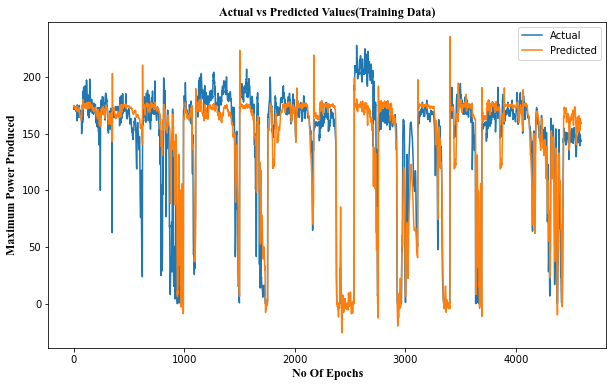

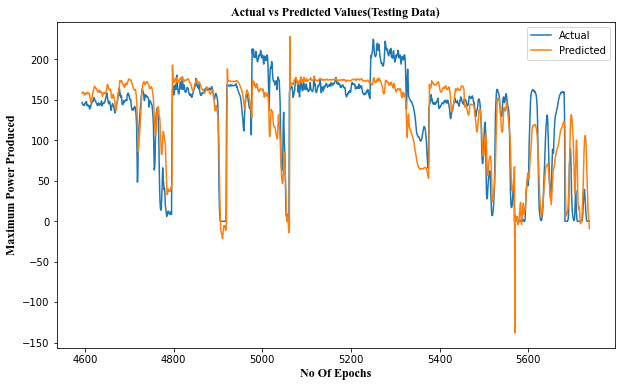

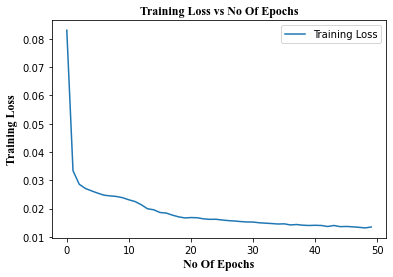

In [21]:
plt.figure(figsize=(10, 6))
plt.plot(df.index[:train_size-time_steps], y_train_is, label='Actual')
plt.plot(df.index[:train_size-time_steps], y_train_pred, label='Predicted')
plt.title("Actual vs Predicted Values(Training Data)", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xlabel("No Of Epochs", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.ylabel("Maximum Power Produced", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xticks()
plt.yticks()
plt.legend()

plt.show()


plt.figure(figsize=(10, 6))
plt.plot(df.index[train_size+time_steps:], y_test_is, label='Actual')
plt.plot(df.index[train_size+time_steps:], y_pred, label='Predicted')
plt.title("Actual vs Predicted Values(Testing Data)" , fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xlabel("No Of Epochs", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.ylabel("Maximum Power Produced", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xticks()
plt.yticks()
plt.legend(loc = 'upper right')

plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.title("Training Loss vs No Of Epochs" , fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xlabel("No Of Epochs", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.ylabel("Training Loss", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xticks()
plt.yticks()
plt.legend()
plt.show(model)

In [22]:
results = results.append({"Model_name":"LSTM Neural Network","RMSE": np.sqrt(mse)}, ignore_index = True)
results

,Model_name,RMSE
0,Radial Basis Function Neural Network,29.711280
1,LSTM Neural Network,29.638446


# Modular Neural Network

In [23]:


X = df.copy()[['Temperature(Â°C)', "Irradiance(W/m2)"]].values
y = df.copy()['Power(Watts)'].values

scaler_X =  MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

train_size = int(len(df) * 0.8)
X_train, X_test = X_scaled[:train_size], X_scaled[train_size:]
y_train, y_test = y_scaled[:train_size], y_scaled[train_size:]

input_shape = (2,)

inputs = layers.Input(shape=input_shape, name="inputs")

x = layers.Dense(25, activation="relu", name="dense1")(inputs)


outputs = layers.Dense(1, activation="linear", name="outputs")(x)

model = keras.Model(inputs=inputs, outputs=outputs, name="modular_nn")

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.01), loss="mse"
)

history = model.fit(X_train, y_train, epochs=50, batch_size=16, verbose=1, validation_data=(X_test, y_test))






Epoch 1/50
287/287 [==============================] - 2s 4ms/step - loss: 0.0367 - val_loss: 0.0227
Epoch 2/50
287/287 [==============================] - 1s 3ms/step - loss: 0.0170 - val_loss: 0.0220
Epoch 3/50
287/287 [==============================] - 1s 3ms/step - loss: 0.0163 - val_loss: 0.0229
Epoch 4/50
287/287 [==============================] - 1s 3ms/step - loss: 0.0156 - val_loss: 0.0201
Epoch 5/50
287/287 [==============================] - 1s 3ms/step - loss: 0.0152 - val_loss: 0.0216
Epoch 6/50
287/287 [==============================] - 1s 3ms/step - loss: 0.0150 - val_loss: 0.0213
Epoch 7/50
287/287 [==============================] - 1s 3ms/step - loss: 0.0147 - val_loss: 0.0206
Epoch 8/50
287/287 [==============================] - 1s 3ms/step - loss: 0.0147 - val_loss: 0.0196
Epoch 9/50
287/287 [==============================] - 1s 3ms/step - loss: 0.0147 - val_loss: 0.0192
Epoch 10/50
287/287 [==============================] - 1s 3ms/step - loss: 0.0145 - val_loss: 0.0209

In [24]:
y_pred = model.predict(X_test)
y_pred_orig = scaler_y.inverse_transform(y_pred)

y_train_pred = model.predict(X_train)
y_train_pred_orig = scaler_y.inverse_transform(y_train_pred)

rmse_1 = np.sqrt(mean_squared_error(y[train_size:], y_pred_orig))

rmse_train = np.sqrt(mean_squared_error(y[:train_size], y_train_pred_orig))

print(f'Test Root Mean Squared Error: {rmse_1:.10f}')
print(f'Train Root Mean Squared Error: {rmse_train:.10f}')
print(f'\n')
model.summary()

144/144 [==============================] - 0s 2ms/step
Test Root Mean Squared Error: 26.3715079946
Train Root Mean Squared Error: 23.8976917199


Model: "modular_nn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 2)]               0         
                                                                 
 dense1 (Dense)              (None, 25)                75        
                                                                 
 outputs (Dense)             (None, 1)                 26        
                                                                 
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


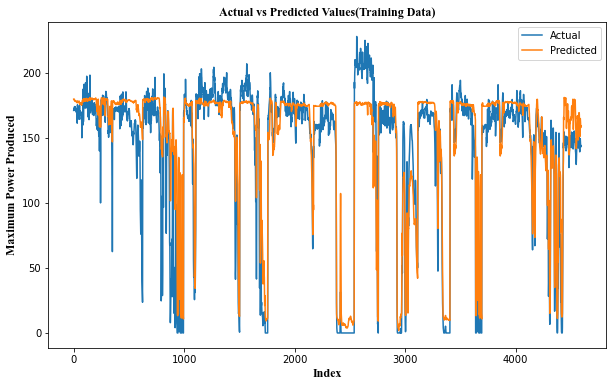

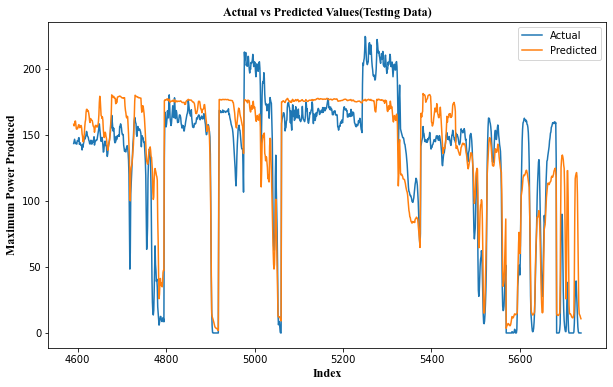

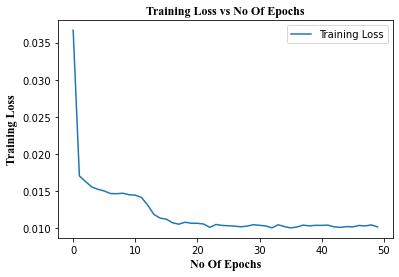

In [25]:
plt.figure(figsize=(10, 6))
plt.plot(df.index[:train_size], y[:train_size], label='Actual')
plt.plot(df.index[:train_size], y_train_pred_orig, label='Predicted')
plt.title("Actual vs Predicted Values(Training Data)", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xlabel("Index", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.ylabel("Maximum Power Produced", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xticks()
plt.yticks()
plt.legend()

plt.show()


plt.figure(figsize=(10, 6))
plt.plot(df.index[train_size:], y[train_size:], label='Actual')
plt.plot(df.index[train_size:], y_pred_orig, label='Predicted')
plt.title("Actual vs Predicted Values(Testing Data)" , fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xlabel("Index", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.ylabel("Maximum Power Produced", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xticks()
plt.yticks()
plt.legend(loc = 'upper right')

plt.show()


plt.plot(history.history['loss'], label='Training Loss')
plt.title("Training Loss vs No Of Epochs" , fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xlabel("No Of Epochs", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.ylabel("Training Loss", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xticks()
plt.yticks()
plt.legend()
plt.show(model)

In [26]:
results = results.append({"Model_name":"Modular Neural Network","RMSE": rmse_1}, ignore_index = True)
results

,Model_name,RMSE
0,Radial Basis Function Neural Network,29.711280
1,LSTM Neural Network,29.638446
2,Modular Neural Network,26.371508


# Linear Regression (G and T) 

In [27]:

X = df[[ 'Irradiance(W/m2)', 'Temperature(Â°C)']].values
y = df["Power(Watts)"].values

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

train_size = int(len(df) * 0.8)
X_train, X_test = X_scaled[:train_size], X_scaled[train_size:]
y_train, y_test = y_scaled[:train_size], y_scaled[train_size:]



reg_model = LinearRegression()

reg_model.fit(X_train, y_train)

y_pred = reg_model.predict(X_test)
mse_4 = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse_4:.10f}')
b0 = reg_model.intercept_[0]
b = reg_model.coef_

print("Regression equation: Y = P = {:.2f}T + {:.2f}IR - {:.2f}".format(b[0][0], b[0][1], abs(b0)))

Mean Squared Error: 0.0259062068
Regression equation: Y = P = 1.28T + -0.08IR - 0.29


In [28]:
y_pred = reg_model.predict(X_test)
y_pred_orig = scaler_y.inverse_transform(y_pred)

y_train_pred = reg_model.predict(X_train)
y_train_pred_orig = scaler_y.inverse_transform(y_train_pred)

rmse_1 = np.sqrt(mean_squared_error(y[train_size:], y_pred_orig))

rmse_train = np.sqrt(mean_squared_error(y[:train_size], y_train_pred_orig))

print(f'Test Root Mean Squared Error: {rmse_1:.10f}')
print(f'Train Root Mean Squared Error: {rmse_train:.10f}')

Test Root Mean Squared Error: 36.6625957912
Train Root Mean Squared Error: 31.6134135645


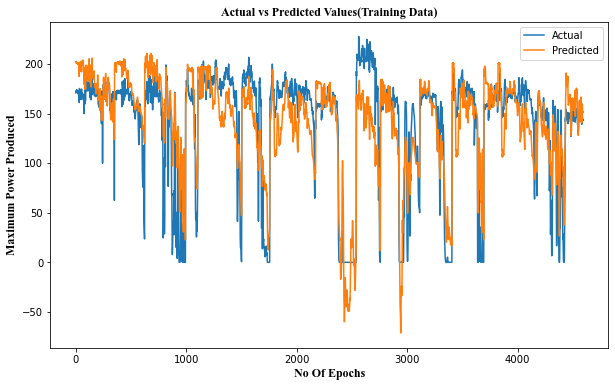

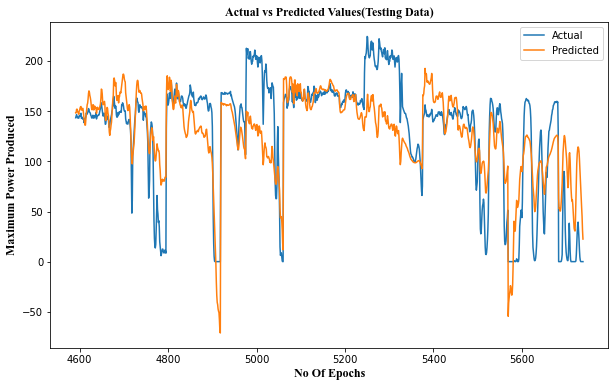

In [29]:
plt.figure(figsize=(10, 6))
plt.plot(df.index[:train_size], y[:train_size], label='Actual')
plt.plot(df.index[:train_size], y_train_pred_orig, label='Predicted')
plt.title("Actual vs Predicted Values(Training Data)", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xlabel("No Of Epochs", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.ylabel("Maximum Power Produced", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xticks()
plt.yticks()
plt.legend()

plt.show()


plt.figure(figsize=(10, 6))
plt.plot(df.index[train_size:], y[train_size:], label='Actual')
plt.plot(df.index[train_size:], y_pred_orig, label='Predicted')
plt.title("Actual vs Predicted Values(Testing Data)" , fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xlabel("No Of Epochs", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.ylabel("Maximum Power Produced", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xticks()
plt.yticks()
plt.legend(loc = 'upper right')

plt.show()

In [30]:
results = results.append({"Model_name":"Linear Regression(G and T)","RMSE": rmse_1}, ignore_index = True)
results

,Model_name,RMSE
0,Radial Basis Function Neural Network,29.711280
1,LSTM Neural Network,29.638446
2,Modular Neural Network,26.371508
3,Linear Regression(G and T),36.662596


# Support Vector Machines

In [31]:
X = df[['Irradiance(W/m2)', 'Irradiance(W/m2)']].values
y = df["Power(Watts)"].values

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

train_size = int(len(df) * 0.8)
X_train, X_test = X_scaled[:train_size], X_scaled[train_size:]
y_train, y_test = y_scaled[:train_size], y_scaled[train_size:]



model = SVR(kernel='rbf')

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mse_5 = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse_5:.10f}')

Mean Squared Error: 0.0154296200


In [32]:
y_pred = model.predict(X_test)
y_pred_orig = scaler_y.inverse_transform(y_pred.reshape(-1, 1))

y_train_pred = model.predict(X_train)
y_train_pred_orig = scaler_y.inverse_transform(y_train_pred.reshape(-1, 1))

rmse_1 = np.sqrt(mean_squared_error(y[train_size:], y_pred_orig))

rmse_train = np.sqrt(mean_squared_error(y[:train_size], y_train_pred_orig))

print(f'Test Root Mean Squared Error: {rmse_1:.10f}')
print(f'Train Root Mean Squared Error: {rmse_train:.10f}')

Test Root Mean Squared Error: 28.2942972448
Train Root Mean Squared Error: 24.8304202656


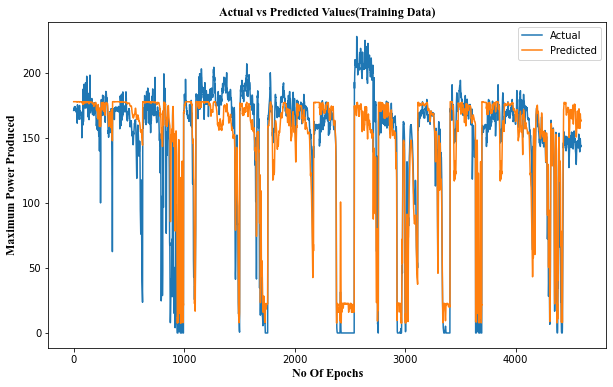

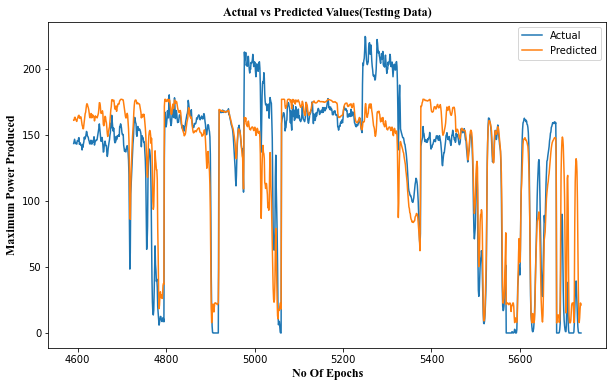

In [33]:
plt.figure(figsize=(10, 6))
plt.plot(df.index[:train_size], y[:train_size], label='Actual')
plt.plot(df.index[:train_size], y_train_pred_orig, label='Predicted')
plt.title("Actual vs Predicted Values(Training Data)", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xlabel("No Of Epochs", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.ylabel("Maximum Power Produced", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xticks()
plt.yticks()
plt.legend()

plt.show()


plt.figure(figsize=(10, 6))
plt.plot(df.index[train_size:], y[train_size:], label='Actual')
plt.plot(df.index[train_size:], y_pred_orig, label='Predicted')
plt.title("Actual vs Predicted Values(Testing Data)" , fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xlabel("No Of Epochs", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.ylabel("Maximum Power Produced", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xticks()
plt.yticks()
plt.legend(loc = 'upper right')

plt.show()

In [34]:
results = results.append({"Model_name":"Support Vector Machines","RMSE": rmse_1}, ignore_index = True)
results

,Model_name,RMSE
0,Radial Basis Function Neural Network,29.711280
1,LSTM Neural Network,29.638446
2,Modular Neural Network,26.371508
3,Linear Regression(G and T),36.662596
4,Support Vector Machines,28.294297


# Decision Tree Regressor

In [35]:
X = df[['Temperature(Â°C)', 'Irradiance(W/m2)']].values
y = df["Power(Watts)"].values

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

train_size = int(len(df) * 0.8)
X_train, X_test = X_scaled[:train_size], X_scaled[train_size:]
y_train, y_test = y_scaled[:train_size], y_scaled[train_size:]

model = DecisionTreeRegressor(max_depth= 10, min_samples_leaf=80, random_state=42)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

y_pred = model.predict(X_test)
y_pred_orig = scaler_y.inverse_transform(y_pred.reshape(-1, 1))

y_train_pred = model.predict(X_train)
y_train_pred_orig = scaler_y.inverse_transform(y_train_pred.reshape(-1, 1))

rmse_1 = np.sqrt(mean_squared_error(y[train_size:], y_pred_orig))

rmse_train = np.sqrt(mean_squared_error(y[:train_size], y_train_pred_orig))

print(f'Test Root Mean Squared Error: {rmse_1:.10f}')
print(f'Train Root Mean Squared Error: {rmse_train:.10f}')

Test Root Mean Squared Error: 24.7008834120
Train Root Mean Squared Error: 19.6063968232


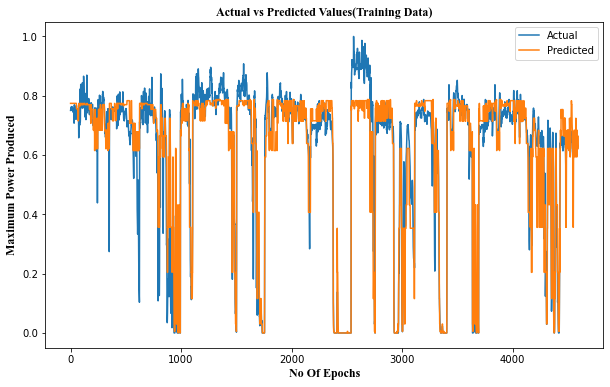

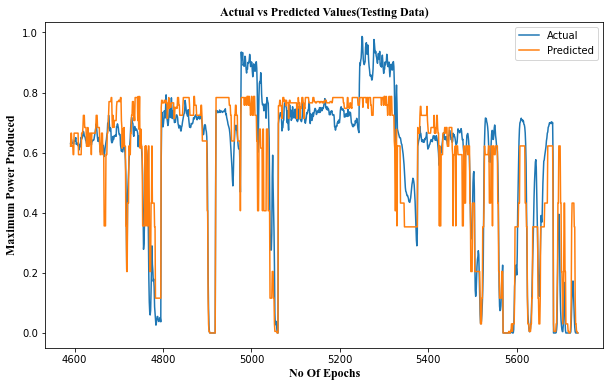

In [36]:
plt.figure(figsize=(10, 6))
plt.plot(df.index[:train_size], y_train, label='Actual')
plt.plot(df.index[:train_size], y_train_pred, label='Predicted')
plt.title("Actual vs Predicted Values(Training Data)", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xlabel("No Of Epochs", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.ylabel("Maximum Power Produced", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xticks()
plt.yticks()
plt.legend()

plt.show()


plt.figure(figsize=(10, 6))
plt.plot(df.index[train_size:], y_test, label='Actual')
plt.plot(df.index[train_size:], y_pred, label='Predicted')
plt.title("Actual vs Predicted Values(Testing Data)" , fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xlabel("No Of Epochs", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.ylabel("Maximum Power Produced", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xticks()
plt.yticks()
plt.legend(loc = 'upper right')

plt.show()

In [37]:
results = results.append({"Model_name":"Decision Tree Regressor","RMSE": rmse_1}, ignore_index = True)
results

,Model_name,RMSE
0,Radial Basis Function Neural Network,29.711280
1,LSTM Neural Network,29.638446
2,Modular Neural Network,26.371508
3,Linear Regression(G and T),36.662596
4,Support Vector Machines,28.294297
5,Decision Tree Regressor,24.700883


# Random forest regressor

In [38]:



X = df[['Temperature(Â°C)', 'Irradiance(W/m2)']].values
y = df["Power(Watts)"].values

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

train_size = int(len(df) * 0.8)
X_train, X_test = X_scaled[:train_size], X_scaled[train_size:]
y_train, y_test = y_scaled[:train_size], y_scaled[train_size:]

n_estimators = 200  # number of decision trees
model = RandomForestRegressor(n_estimators=n_estimators, max_depth= 20,
                              min_samples_leaf=62, min_samples_split=15, random_state=42)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

y_pred = model.predict(X_test)
y_pred_orig = scaler_y.inverse_transform(y_pred.reshape(-1, 1))

y_train_pred = model.predict(X_train)
y_train_pred_orig = scaler_y.inverse_transform(y_train_pred.reshape(-1, 1))

rmse_1 = np.sqrt(mean_squared_error(y[train_size:], y_pred_orig))

rmse_train = np.sqrt(mean_squared_error(y[:train_size], y_train_pred_orig))

print(f'Test Root Mean Squared Error: {rmse_1:.10f}')
print(f'Train Root Mean Squared Error: {rmse_train:.10f}')

Test Root Mean Squared Error: 23.7012284535
Train Root Mean Squared Error: 19.3038779049


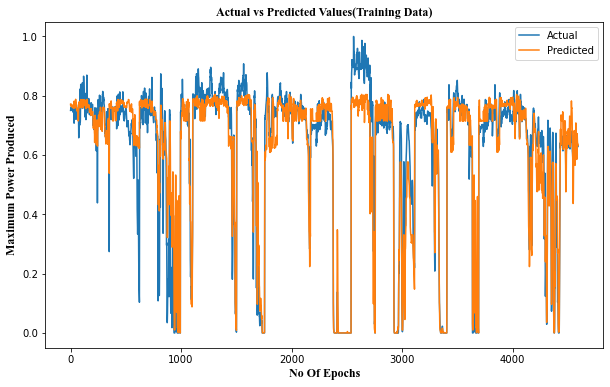

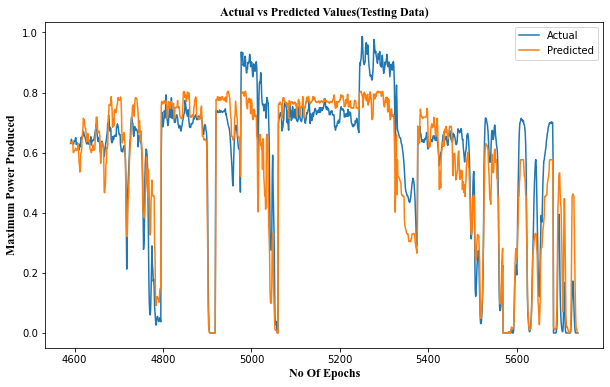

In [39]:
plt.figure(figsize=(10, 6))
plt.plot(df.index[:train_size], y_train, label='Actual')
plt.plot(df.index[:train_size], y_train_pred, label='Predicted')
plt.title("Actual vs Predicted Values(Training Data)", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xlabel("No Of Epochs", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.ylabel("Maximum Power Produced", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xticks()
plt.yticks()
plt.legend()

plt.show()


plt.figure(figsize=(10, 6))
plt.plot(df.index[train_size:], y_test, label='Actual')
plt.plot(df.index[train_size:], y_pred, label='Predicted')
plt.title("Actual vs Predicted Values(Testing Data)" , fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xlabel("No Of Epochs", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.ylabel("Maximum Power Produced", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xticks()
plt.yticks()
plt.legend(loc = 'upper right')

plt.show()

In [40]:
results = results.append({"Model_name":"Random forest Regressor","RMSE": rmse_1}, ignore_index = True)
results

,Model_name,RMSE
0,Radial Basis Function Neural Network,29.711280
1,LSTM Neural Network,29.638446
2,Modular Neural Network,26.371508
3,Linear Regression(G and T),36.662596
4,Support Vector Machines,28.294297
5,Decision Tree Regressor,24.700883
6,Random forest Regressor,23.701228


# Orthogonal linear regression

In [41]:
X = df.copy()[['Temperature(Â°C)', "Irradiance(W/m2)"]].values
y = df.copy()['Power(Watts)'].values

scaler_X =  MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

train_size = int(len(df) * 0.8)
X_train, X_test = X_scaled[:train_size], X_scaled[train_size:]
y_train, y_test = y_scaled[:train_size], y_scaled[train_size:]

model = OrthogonalMatchingPursuit()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))

In [42]:
y_pred = model.predict(X_test)
y_pred_orig = scaler_y.inverse_transform(y_pred.reshape(-1, 1))

y_train_pred = model.predict(X_train)
y_train_pred_orig = scaler_y.inverse_transform(y_train_pred.reshape(-1, 1))

rmse_1 = np.sqrt(mean_squared_error(y[train_size:], y_pred_orig))

rmse_train = np.sqrt(mean_squared_error(y[:train_size], y_train_pred_orig))

print(f'Test Root Mean Squared Error: {rmse_1:.10f}')

results = results.append({"Model_name":"Orthogonal linear regression","RMSE": rmse_1}, ignore_index = True)
results

Test Root Mean Squared Error: 36.4857437520


,Model_name,RMSE
0,Radial Basis Function Neural Network,29.711280
1,LSTM Neural Network,29.638446
2,Modular Neural Network,26.371508
3,Linear Regression(G and T),36.662596
4,Support Vector Machines,28.294297
5,Decision Tree Regressor,24.700883
6,Random forest Regressor,23.701228
7,Orthogonal linear regression,36.485744


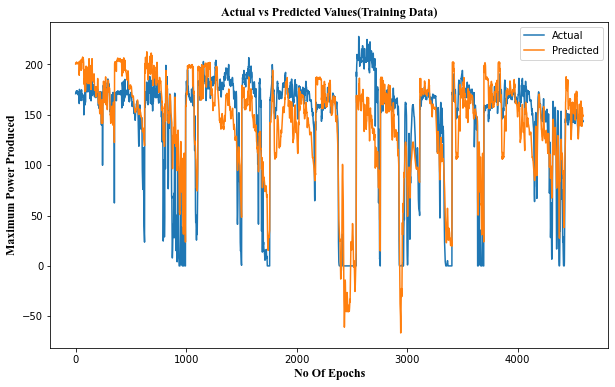

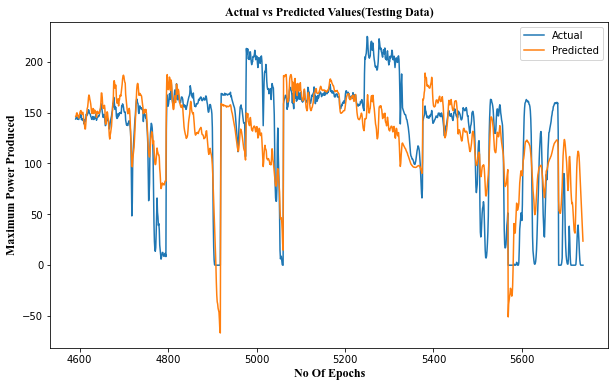

In [43]:
plt.figure(figsize=(10, 6))
plt.plot(df.index[:train_size], y[:train_size], label='Actual')
plt.plot(df.index[:train_size], y_train_pred_orig, label='Predicted')
plt.title("Actual vs Predicted Values(Training Data)", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xlabel("No Of Epochs", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.ylabel("Maximum Power Produced", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xticks()
plt.yticks()
plt.legend()

plt.show()


plt.figure(figsize=(10, 6))
plt.plot(df.index[train_size:], y[train_size:], label='Actual')
plt.plot(df.index[train_size:], y_pred_orig, label='Predicted')
plt.title("Actual vs Predicted Values(Testing Data)" , fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xlabel("No Of Epochs", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.ylabel("Maximum Power Produced", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xticks()
plt.yticks()
plt.legend(loc = 'upper right')

plt.show()

# Quantile Linear regression

In [38]:
import numpy as np
from sklearn.linear_model import OrthogonalMatchingPursuit
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm

X = df.copy()[['Temperature(Â°C)', "Irradiance(W/m2)"]].values
y = df.copy()['Power(Watts)'].values

scaler_X =  MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

train_size = int(len(df) * 0.8)
X_train, X_test = X_scaled[:train_size], X_scaled[train_size:]
y_train, y_test = y_scaled[:train_size], y_scaled[train_size:]


quantile_model = sm.QuantReg(y_train, X_train)
quantile_result = quantile_model.fit(q=0.40)  # Change the quantile value as needed

predicted_power = quantile_result.predict(X)



In [39]:
y_pred = quantile_result.predict(X_test)
y_pred_orig = scaler_y.inverse_transform(y_pred.reshape(-1, 1))

y_train_pred = quantile_result.predict(X_train)
y_train_pred_orig = scaler_y.inverse_transform(y_train_pred.reshape(-1, 1))

rmse_1 = np.sqrt(mean_squared_error(y[train_size:], y_pred_orig))

rmse_train = np.sqrt(mean_squared_error(y[:train_size], y_train_pred_orig))

print(f'Test Root Mean Squared Error: {rmse_1:.10f}')
print(f'Train Root Mean Squared Error: {rmse_train:.10f}')

results = results.append({"Model_name":"Quantile linear regression","RMSE": rmse_1}, ignore_index = True)
results

Test Root Mean Squared Error: 40.2012322994
Train Root Mean Squared Error: 35.0124540199


,Model_name,RMSE
0,Quantile linear regression,61.344179
1,Quantile linear regression,40.547775
2,Quantile linear regression,40.830437
3,Quantile linear regression,40.527272
4,Quantile linear regression,40.296410
5,Quantile linear regression,40.977381
6,Quantile linear regression,41.258636
7,Quantile linear regression,41.809508
8,Quantile linear regression,40.242261
9,Quantile linear regression,40.208259


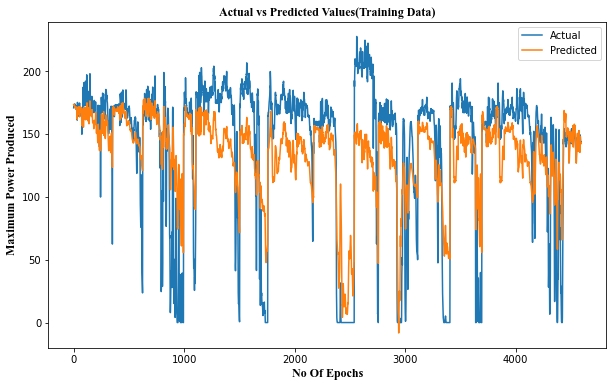

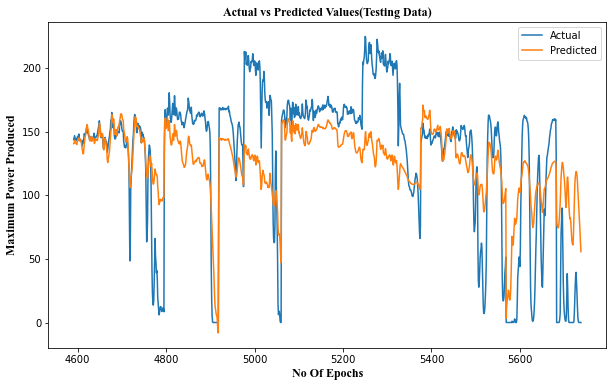

In [46]:
plt.figure(figsize=(10, 6))
plt.plot(df.index[:train_size], y[:train_size], label='Actual')
plt.plot(df.index[:train_size], y_train_pred_orig, label='Predicted')
plt.title("Actual vs Predicted Values(Training Data)", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xlabel("No Of Epochs", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.ylabel("Maximum Power Produced", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xticks()
plt.yticks()
plt.legend()

plt.show()


plt.figure(figsize=(10, 6))
plt.plot(df.index[train_size:], y[train_size:], label='Actual')
plt.plot(df.index[train_size:], y_pred_orig, label='Predicted')
plt.title("Actual vs Predicted Values(Testing Data)" , fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xlabel("No Of Epochs", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.ylabel("Maximum Power Produced", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xticks()
plt.yticks()
plt.legend(loc = 'upper right')

plt.show()

# Linear Regression(G^2 and T)

In [47]:
X = df[['Temperature(Â°C)', 'Irradiance(W/m2)']]
X["Irradiance(W/m2)"] = X["Irradiance(W/m2)"]**2
X = X.values
y = df["Power(Watts)"].values

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

train_size = int(len(df) * 0.8)
X_train, X_test = X_scaled[:train_size], X_scaled[train_size:]
y_train, y_test = y_scaled[:train_size], y_scaled[train_size:]



reg_model = LinearRegression()

reg_model.fit(X_train, y_train)

y_pred = reg_model.predict(X_test)
mse_4 = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse_4:.10f}')
b0 = reg_model.intercept_[0]
b = reg_model.coef_

print("Regression equation: Y = P = {:.2f}T + {:.2f}IR^2 - {:.2f}".format(b[0][0], b[0][1], abs(b0)))

Mean Squared Error: 0.0284679513
Regression equation: Y = P = -0.15T + 1.06IR^2 - 0.06


In [48]:
y_pred = reg_model.predict(X_test)
y_pred_orig = scaler_y.inverse_transform(y_pred)

y_train_pred = reg_model.predict(X_train)
y_train_pred_orig = scaler_y.inverse_transform(y_train_pred)

rmse_1 = np.sqrt(mean_squared_error(y[train_size:], y_pred_orig))

rmse_train = np.sqrt(mean_squared_error(y[:train_size], y_train_pred_orig))

print(f'Test Root Mean Squared Error: {rmse_1:.10f}')
print(f'Train Root Mean Squared Error: {rmse_train:.10f}')

results = results.append({"Model_name":"Linear regression(G^2 and T)","RMSE": rmse_1}, ignore_index = True)
results

Test Root Mean Squared Error: 38.4325678983
Train Root Mean Squared Error: 33.8681344997


,Model_name,RMSE
0,Radial Basis Function Neural Network,29.711280
1,LSTM Neural Network,29.638446
2,Modular Neural Network,26.371508
3,Linear Regression(G and T),36.662596
4,Support Vector Machines,28.294297
5,Decision Tree Regressor,24.700883
6,Random forest Regressor,23.701228
7,Orthogonal linear regression,36.485744
8,Quantile linear regression,41.258636
9,Linear regression(G^2 and T),38.432568


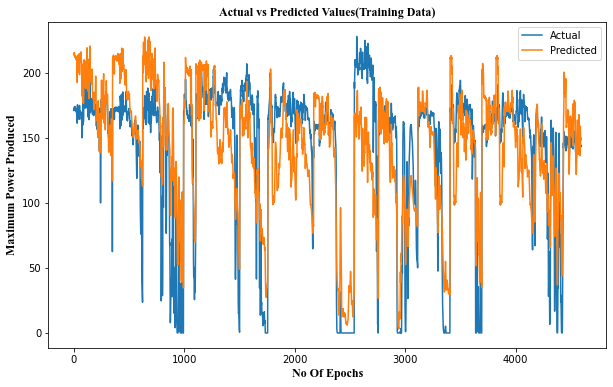

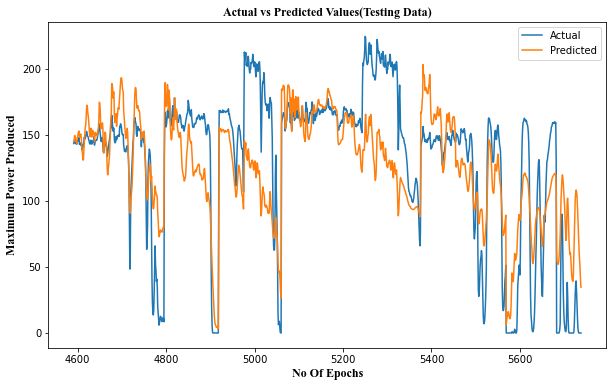

In [49]:
plt.figure(figsize=(10, 6))
plt.plot(df.index[:train_size], y[:train_size], label='Actual')
plt.plot(df.index[:train_size], y_train_pred_orig, label='Predicted')
plt.title("Actual vs Predicted Values(Training Data)", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xlabel("No Of Epochs", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.ylabel("Maximum Power Produced", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xticks()
plt.yticks()
plt.legend()

plt.show()


plt.figure(figsize=(10, 6))
plt.plot(df.index[train_size:], y[train_size:], label='Actual')
plt.plot(df.index[train_size:], y_pred_orig, label='Predicted')
plt.title("Actual vs Predicted Values(Testing Data)" , fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xlabel("No Of Epochs", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.ylabel("Maximum Power Produced", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xticks()
plt.yticks()
plt.legend(loc = 'upper right')

plt.show()

# Linear Regression(G^2 and T^2)

In [50]:
X = df[['Temperature(Â°C)', 'Irradiance(W/m2)']]
X["Temperature(Â°C)"] = X["Temperature(Â°C)"]**2
X["Irradiance(W/m2)"] = X["Irradiance(W/m2)"]**2
X = X.values
y = df["Power(Watts)"].values

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

train_size = int(len(df) * 0.8)
X_train, X_test = X_scaled[:train_size], X_scaled[train_size:]
y_train, y_test = y_scaled[:train_size], y_scaled[train_size:]



reg_model = LinearRegression()

reg_model.fit(X_train, y_train)

y_pred = reg_model.predict(X_test)
mse_4 = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse_4:.10f}')
b0 = reg_model.intercept_[0]
b = reg_model.coef_

print("Regression equation: Y = P = {:.2f}T + {:.2f}IR^2 - {:.2f}".format(b[0][0], b[0][1], abs(b0)))

Mean Squared Error: 0.0280902507
Regression equation: Y = P = -0.23T + 1.12IR^2 - 0.01


In [51]:
y_pred = reg_model.predict(X_test)
y_pred_orig = scaler_y.inverse_transform(y_pred)

y_train_pred = reg_model.predict(X_train)
y_train_pred_orig = scaler_y.inverse_transform(y_train_pred)

rmse_1 = np.sqrt(mean_squared_error(y[train_size:], y_pred_orig))

rmse_train = np.sqrt(mean_squared_error(y[:train_size], y_train_pred_orig))

print(f'Test Root Mean Squared Error: {rmse_1:.10f}')
print(f'Train Root Mean Squared Error: {rmse_train:.10f}')

results = results.append({"Model_name":"Linear regression(G^2 and T^2)","RMSE": rmse_1}, ignore_index = True)
results

Test Root Mean Squared Error: 38.1767632102
Train Root Mean Squared Error: 33.3680106514


,Model_name,RMSE
0,Radial Basis Function Neural Network,29.711280
1,LSTM Neural Network,29.638446
2,Modular Neural Network,26.371508
3,Linear Regression(G and T),36.662596
4,Support Vector Machines,28.294297
5,Decision Tree Regressor,24.700883
6,Random forest Regressor,23.701228
7,Orthogonal linear regression,36.485744
8,Quantile linear regression,41.258636
9,Linear regression(G^2 and T),38.432568


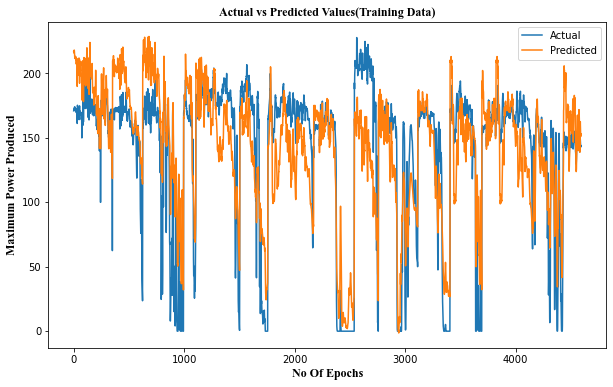

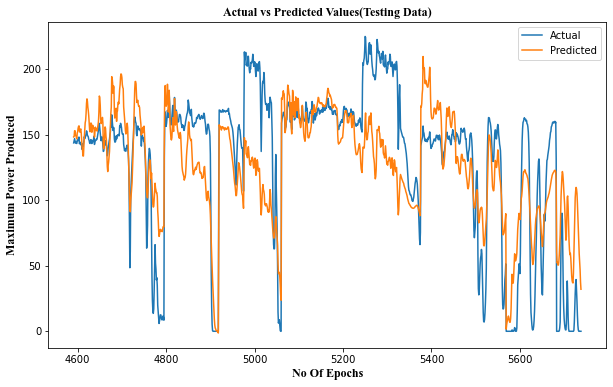

In [52]:
plt.figure(figsize=(10, 6))
plt.plot(df.index[:train_size], y[:train_size], label='Actual')
plt.plot(df.index[:train_size], y_train_pred_orig, label='Predicted')
plt.title("Actual vs Predicted Values(Training Data)", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xlabel("No Of Epochs", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.ylabel("Maximum Power Produced", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xticks()
plt.yticks()
plt.legend()

plt.show()


plt.figure(figsize=(10, 6))
plt.plot(df.index[train_size:], y[train_size:], label='Actual')
plt.plot(df.index[train_size:], y_pred_orig, label='Predicted')
plt.title("Actual vs Predicted Values(Testing Data)" , fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xlabel("No Of Epochs", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.ylabel("Maximum Power Produced", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xticks()
plt.yticks()
plt.legend(loc = 'upper right')

plt.show()

# Linear Regression(G and T^2)

In [53]:
X = df[['Temperature(Â°C)', 'Irradiance(W/m2)']]
X["Temperature(Â°C)"] = X["Temperature(Â°C)"]**2
X = X.values
y = df["Power(Watts)"].values

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

train_size = int(len(df) * 0.8)
X_train, X_test = X_scaled[:train_size], X_scaled[train_size:]
y_train, y_test = y_scaled[:train_size], y_scaled[train_size:]



reg_model = LinearRegression()

reg_model.fit(X_train, y_train)

y_pred = reg_model.predict(X_test)
mse_4 = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse_4:.10f}')
b0 = reg_model.intercept_[0]
b = reg_model.coef_

print("Regression equation: Y = P = {:.2f}T + {:.2f}IR^2 - {:.2f}".format(b[0][0], b[0][1], abs(b0)))

Mean Squared Error: 0.0258611674
Regression equation: Y = P = -0.13T + 1.32IR^2 - 0.32


In [54]:
y_pred = reg_model.predict(X_test)
y_pred_orig = scaler_y.inverse_transform(y_pred)

y_train_pred = reg_model.predict(X_train)
y_train_pred_orig = scaler_y.inverse_transform(y_train_pred)

rmse_1 = np.sqrt(mean_squared_error(y[train_size:], y_pred_orig))

rmse_train = np.sqrt(mean_squared_error(y[:train_size], y_train_pred_orig))

print(f'Test Root Mean Squared Error: {rmse_1:.10f}')
print(f'Train Root Mean Squared Error: {rmse_train:.10f}')

results = results.append({"Model_name":"Linear regression(G and T^2)", "RMSE": rmse_1}, ignore_index = True)
results

Test Root Mean Squared Error: 36.6307118816
Train Root Mean Squared Error: 31.4132955839


,Model_name,RMSE
0,Radial Basis Function Neural Network,29.711280
1,LSTM Neural Network,29.638446
2,Modular Neural Network,26.371508
3,Linear Regression(G and T),36.662596
4,Support Vector Machines,28.294297
5,Decision Tree Regressor,24.700883
6,Random forest Regressor,23.701228
7,Orthogonal linear regression,36.485744
8,Quantile linear regression,41.258636
9,Linear regression(G^2 and T),38.432568


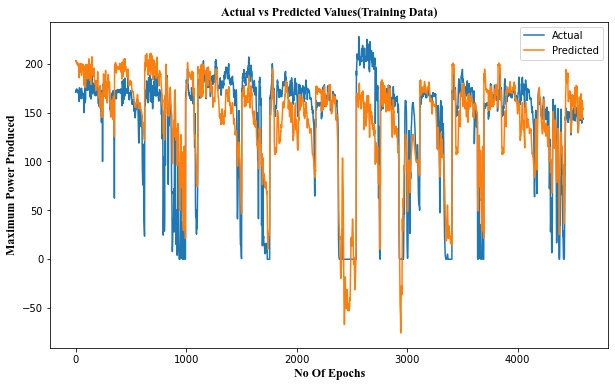

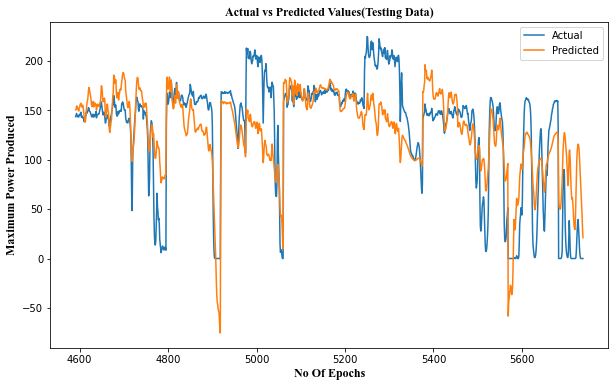

In [55]:
plt.figure(figsize=(10, 6))
plt.plot(df.index[:train_size], y[:train_size], label='Actual')
plt.plot(df.index[:train_size], y_train_pred_orig, label='Predicted')
plt.title("Actual vs Predicted Values(Training Data)", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xlabel("No Of Epochs", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.ylabel("Maximum Power Produced", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xticks()
plt.yticks()
plt.legend()

plt.show()


plt.figure(figsize=(10, 6))
plt.plot(df.index[train_size:], y[train_size:], label='Actual')
plt.plot(df.index[train_size:], y_pred_orig, label='Predicted')
plt.title("Actual vs Predicted Values(Testing Data)" , fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xlabel("No Of Epochs", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.ylabel("Maximum Power Produced", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xticks()
plt.yticks()
plt.legend(loc = 'upper right')

plt.show()

# Ridge Regression

In [56]:

X = df[[ 'Irradiance(W/m2)', 'Temperature(Â°C)']].values
y = df["Power(Watts)"].values

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

train_size = int(len(df) * 0.8)
X_train, X_test = X_scaled[:train_size], X_scaled[train_size:]
y_train, y_test = y_scaled[:train_size], y_scaled[train_size:]



reg_model = Ridge(alpha=0.3)

reg_model.fit(X_train, y_train)

y_pred = reg_model.predict(X_test)
mse_4 = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse_4:.10f}')
b0 = reg_model.intercept_[0]
b = reg_model.coef_

y_pred = reg_model.predict(X_test)
y_pred_orig = scaler_y.inverse_transform(y_pred.reshape(-1, 1))

y_train_pred = reg_model.predict(X_train)
y_train_pred_orig = scaler_y.inverse_transform(y_train_pred.reshape(-1, 1))

rmse_1 = np.sqrt(mean_squared_error(y[train_size:], y_pred_orig))

rmse_train = np.sqrt(mean_squared_error(y[:train_size], y_train_pred_orig))

print(f'Test Root Mean Squared Error: {rmse_1:.10f}')
print(f'Train Root Mean Squared Error: {rmse_train:.10f}')

results = results.append({"Model_name":"Ridge regression","RMSE": rmse_1}, ignore_index = True)
results

Mean Squared Error: 0.0258966093
Test Root Mean Squared Error: 36.6558038887
Train Root Mean Squared Error: 31.6138435334


,Model_name,RMSE
0,Radial Basis Function Neural Network,29.711280
1,LSTM Neural Network,29.638446
2,Modular Neural Network,26.371508
3,Linear Regression(G and T),36.662596
4,Support Vector Machines,28.294297
5,Decision Tree Regressor,24.700883
6,Random forest Regressor,23.701228
7,Orthogonal linear regression,36.485744
8,Quantile linear regression,41.258636
9,Linear regression(G^2 and T),38.432568


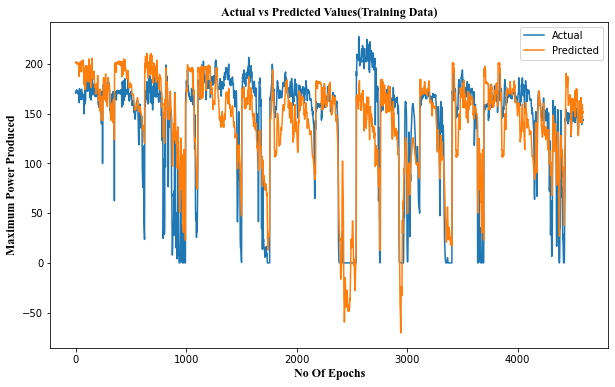

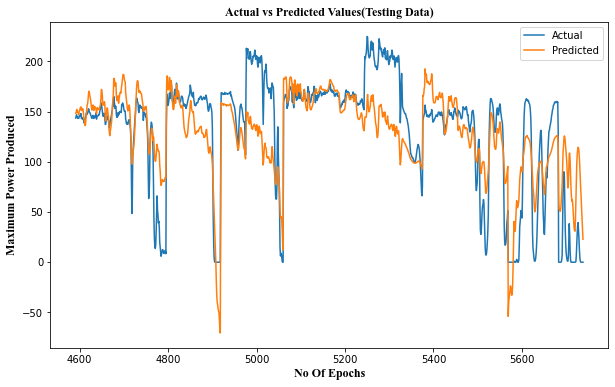

In [57]:
plt.figure(figsize=(10, 6))
plt.plot(df.index[:train_size], y[:train_size], label='Actual')
plt.plot(df.index[:train_size], y_train_pred_orig, label='Predicted')
plt.title("Actual vs Predicted Values(Training Data)", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xlabel("No Of Epochs", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.ylabel("Maximum Power Produced", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xticks()
plt.yticks()
plt.legend()

plt.show()


plt.figure(figsize=(10, 6))
plt.plot(df.index[train_size:], y[train_size:], label='Actual')
plt.plot(df.index[train_size:], y_pred_orig, label='Predicted')
plt.title("Actual vs Predicted Values(Testing Data)" , fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xlabel("No Of Epochs", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.ylabel("Maximum Power Produced", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xticks()
plt.yticks()
plt.legend(loc = 'upper right')

plt.show()

# Kernel Ridge Regression

In [65]:
from sklearn.kernel_ridge import KernelRidge

X = df[[ 'Irradiance(W/m2)', 'Temperature(Â°C)']].values
y = df["Power(Watts)"].values

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

train_size = int(len(df) * 0.8)
X_train, X_test = X_scaled[:train_size], X_scaled[train_size:]
y_train, y_test = y_scaled[:train_size], y_scaled[train_size:]



reg_model = KernelRidge(kernel='rbf', alpha=0.1)

reg_model.fit(X_train, y_train)

y_pred = reg_model.predict(X_test)
mse_4 = mean_squared_error(y_test, y_pred)


y_pred = reg_model.predict(X_test)
y_pred_orig = scaler_y.inverse_transform(y_pred.reshape(-1, 1))

y_train_pred = reg_model.predict(X_train)
y_train_pred_orig = scaler_y.inverse_transform(y_train_pred.reshape(-1, 1))

rmse_1 = np.sqrt(mean_squared_error(y[train_size:], y_pred_orig))

rmse_train = np.sqrt(mean_squared_error(y[:train_size], y_train_pred_orig))

print(f'Test Root Mean Squared Error: {rmse_1:.10f}')
print(f'Train Root Mean Squared Error: {rmse_train:.10f}')

results = results.append({"Model_name":"Kernal Ridge regression","RMSE": rmse_1}, ignore_index = True)
results

Test Root Mean Squared Error: 31.7354168404
Train Root Mean Squared Error: 25.7678196402


,Model_name,RMSE
0,Radial Basis Function Neural Network,29.711280
1,LSTM Neural Network,29.638446
2,Modular Neural Network,26.371508
3,Linear Regression(G and T),36.662596
4,Support Vector Machines,28.294297
5,Decision Tree Regressor,24.700883
6,Random forest Regressor,23.701228
7,Orthogonal linear regression,36.485744
8,Quantile linear regression,41.258636
9,Linear regression(G^2 and T),38.432568


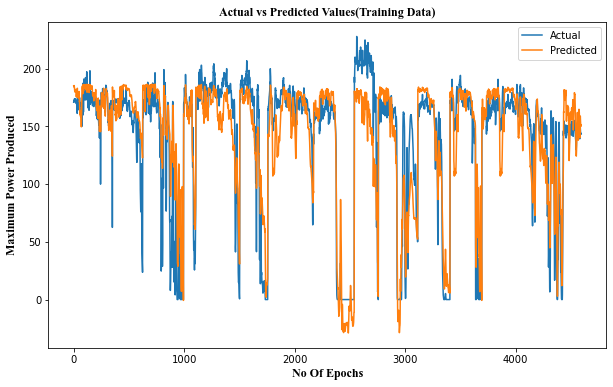

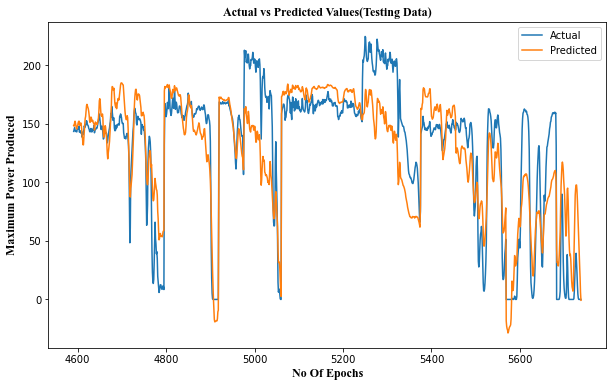

In [59]:
plt.figure(figsize=(10, 6))
plt.plot(df.index[:train_size], y[:train_size], label='Actual')
plt.plot(df.index[:train_size], y_train_pred_orig, label='Predicted')
plt.title("Actual vs Predicted Values(Training Data)", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xlabel("No Of Epochs", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.ylabel("Maximum Power Produced", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xticks()
plt.yticks()
plt.legend()

plt.show()


plt.figure(figsize=(10, 6))
plt.plot(df.index[train_size:], y[train_size:], label='Actual')
plt.plot(df.index[train_size:], y_pred_orig, label='Predicted')
plt.title("Actual vs Predicted Values(Testing Data)" , fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xlabel("No Of Epochs", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.ylabel("Maximum Power Produced", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xticks()
plt.yticks()
plt.legend(loc = 'upper right')

plt.show()

In [61]:
results.sort_values("RMSE").reset_index().drop("index", axis = 1)

,Model_name,RMSE
0,Random forest Regressor,23.701228
1,Decision Tree Regressor,24.700883
2,Modular Neural Network,26.371508
3,Support Vector Machines,28.294297
4,LSTM Neural Network,29.638446
5,Radial Basis Function Neural Network,29.711280
6,Kernal Ridge regression,31.735417
7,Orthogonal linear regression,36.485744
8,Linear regression(G and T^2),36.630712
9,Ridge regression,36.655804
